In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
#TF2
#from tensorflow.python.compiler.tensorrt import trt_convert as trt
#TF1
import tensorflow.contrib.tensorrt as trt
import tensorflow as tf
import numpy as np

from tensorflow.python.framework import graph_io
from google.colab import drive
from tensorflow.python.platform import gfile
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%pwd

'/content'

In [7]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [8]:
%mkdir ObjectDetection_Retinanet

/content/drive/My Drive/ObjectDetection_Retinanet


In [3]:
%cd /content/drive/My\ Drive/ObjectDetection_Retinanet
!git clone https://github.com/fizyr/keras-retinanet
%cd keras-retinanet
!git checkout 42068ef9e406602d92a1afe2ee7d470f7e9860df
!python setup.py install
!python setup.py build_ext --inplace
%cd ..

/content/drive/My Drive/ObjectDetection_Retinanet
fatal: destination path 'keras-retinanet' already exists and is not an empty directory.
/content/drive/My Drive/ObjectDetection_Retinanet/keras-retinanet
error: Your local changes to the following files would be overwritten by checkout:
	keras_retinanet/bin/convert_model.py
	keras_retinanet/bin/debug.py
	keras_retinanet/bin/evaluate.py
	keras_retinanet/bin/train.py
Please commit your changes or stash them before you switch branches.
Aborting
running install
running bdist_egg
running egg_info
writing keras_retinanet.egg-info/PKG-INFO
writing dependency_links to keras_retinanet.egg-info/dependency_links.txt
writing entry points to keras_retinanet.egg-info/entry_points.txt
writing requirements to keras_retinanet.egg-info/requires.txt
writing top-level names to keras_retinanet.egg-info/top_level.txt
writing manifest file 'keras_retinanet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
runnin

In [4]:
%cd /content/drive/My\ Drive/ObjectDetection_Retinanet
%cd keras-retinanet
!pip install . --user
!python setup.py build_ext --inplace
%cd ..

/content/drive/My Drive/ObjectDetection_Retinanet
/content/drive/My Drive/ObjectDetection_Retinanet/keras-retinanet
Processing /content/drive/My Drive/ObjectDetection_Retinanet/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169727 sha256=937eba5094848fc7c0929df26c3ef49b97ba8c84c9f35fe33d324b331ad56691
  Stored in directory: /root/.cache/pip/wheels/ad/f4/67/09c5756416a6c615c4e2b872936c97c3a33293e2fd3241f3d8
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/

In [5]:
tensor_rt_model_path = 'saved_model_small/trt_graph.pb'

In [6]:
# get frozen graph
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.FastGFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def


trt_graph = get_frozen_graph(tensor_rt_model_path)

Instructions for updating:
Use tf.gfile.GFile.


In [7]:
# Create session and load graph
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')

In [8]:
# Get graph input size
for node in trt_graph.node:
    if 'input_' in node.name:
        size = node.attr['shape'].shape
        image_size = [size.dim[i].size for i in range(1, 4)]
        break
print("image_size: {}".format(image_size))

image_size: [-1, -1, 3]


In [9]:
input_tensor_name = 'input_1:0'
output_tensor_names = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0',
                       'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0',
                       'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0']


boxes_trt = tf_sess.graph.get_tensor_by_name(output_tensor_names[0])
scores_trt = tf_sess.graph.get_tensor_by_name(output_tensor_names[1])
labels_trt = tf_sess.graph.get_tensor_by_name(output_tensor_names[2])

predictions_tf = [boxes_trt, scores_trt, labels_trt]

print("input_tensor_name: {}\noutput_tensor_name: {}".format(
    input_tensor_name, predictions_tf))

input_tensor_name: input_1:0
output_tensor_name: [<tf.Tensor 'filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0' shape=<unknown> dtype=float32>, <tf.Tensor 'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0' shape=<unknown> dtype=float32>, <tf.Tensor 'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0' shape=<unknown> dtype=int32>]


In [64]:
%matplotlib inline

from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import numpy as np
import cv2
import matplotlib.pyplot as plt

# load image
test_image_full_path = 'test/images/badger.jpg'
image = read_image_bgr(test_image_full_path)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)
image = np.expand_dims(image, axis=0)

In [65]:
feed_dict = {input_tensor_name: image}
preds = tf_sess.run(predictions_tf, feed_dict)

In [66]:
boxes = preds[0]
scores = preds[1]
labels = preds[2]

# correct for image scale
boxes /= scale

In [67]:
import time
times = []
for i in range(100):
    start_time = time.time()
    one_prediction = tf_sess.run(predictions_tf, feed_dict)
    delta = (time.time() - start_time)
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

average(sec):0.10,fps:10.48


In [68]:
boxes.shape, scores.shape, labels.shape

((1, 300, 4), (1, 300), (1, 300))

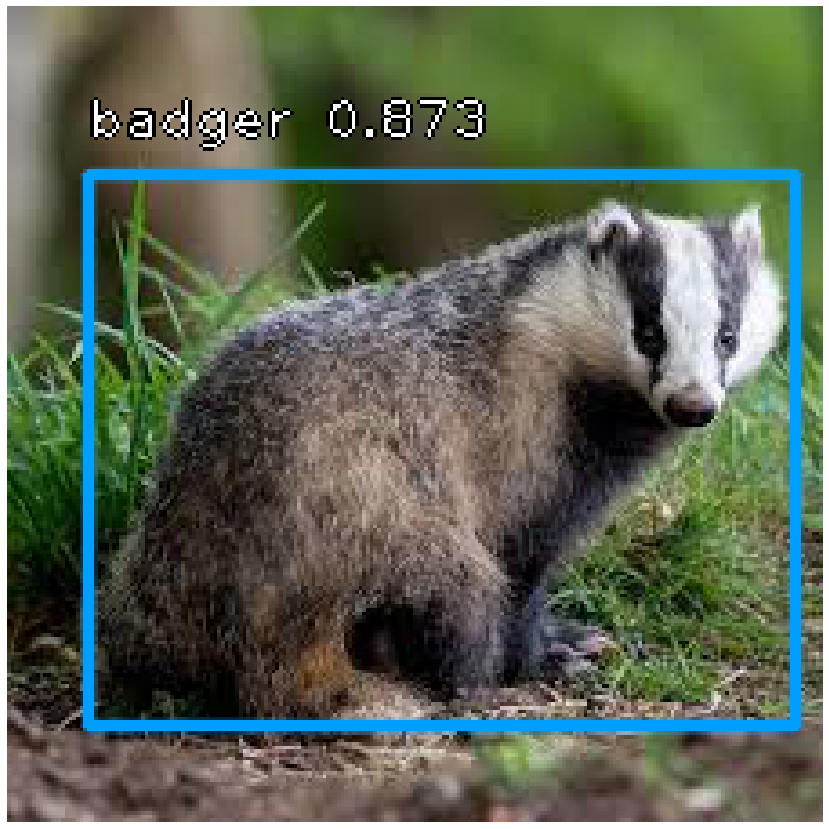

In [69]:
# visualize detections
labels_to_names = {0:'fox', 1:'badger'}

for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
#plt.savefig('prediction.png')
plt.show()